### Imports

In [59]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
import numpy as np
import os
from scipy import optimize

# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.afw.math as afwMath


# Firefly client imports
from IPython.display import IFrame

In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

This notebook requires the package `obs_lsst`, which is not currently distributed in the LSP. If the following cell raises an exception, see the instructions in `welcome_to_FE55.ipynb`.

In [3]:
import eups
assert eups.getSetupVersion("obs_lsst")

### Set up the config for the ISR task.  This essentially turns off all processing other than overscan and bias correction.

In [4]:
isr_config = IsrTask.ConfigClass()

isr_config.doDark=False
isr_config.doFlat=False
isr_config.doFringe=False
isr_config.doDefect=False
isr_config.doAddDistortionModel=False
isr_config.doLinearize=False
isr_config.doSaturationInterpolation=False

### Construct the `IsrTask` with the above configuration

In [5]:
isr = IsrTask(config=isr_config)

### Setup firefly to do image visualization

In [6]:
my_channel = '{}_test_channel'.format(os.environ['USER'])
server = 'https://lsst-lspdev.ncsa.illinois.edu'


ff='{}/firefly/slate.html?__wsch={}'.format(server, my_channel)
IFrame(ff,800,600)

afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.getDisplay(frame=1, 
                                    name=my_channel)

## Calculate gain for a given sensor and amp

In [7]:
def calculate_gains(rtm_path, sensor, hduidx):
    
    '''
    @params
    rtm_path: str
    
    sensor: 0-8
    
    hduidx: 0-15
    
    @returns
    results: array, [('visit1', 'int'), ('visit2', 'int'), ('index', 'int'), ('gain', 'f4'), ('exp_time', 'f4')]
    
    '''
    assert hduidx in range(16)
    
    ## Initialize the Butler to point to RTM data
    butler = Butler(rtm_path)

    ## Get individual exposures
    visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FLAT', 'testType': 'FLAT'}) ## what is 'testType' ??
    gain = {}
    exp_time = {}
    
    #visits = visits[:4]              #Remove when ready to look at all available visits
    
    #Initialize an empty array for storing the output
    nn = int(len(visits) / 2)    
    results = np.empty(nn, dtype=[('visit1', 'int'), ('visit2', 'int'), ('index', 'int'), ('gain', 'f4'), ('exp_time', 'f4')])

    i = 0
    ## Assuming pairs are visits listed one after another
    for visit1, visit2 in zip(visits[:-1:2], visits[1::2]): # loop over pairs of images
        # Get ISR data for first image
        dId = {'visit': visit1, 'detector': sensor}
        raw1 = butler.get('raw', **dId)
        bias1 = butler.get('bias', **dId)
        time1 = raw1.getInfo().getVisitInfo().getExposureTime()

        # Get ISR data for second image
        dId = {'visit': visit2, 'detector': sensor}
        raw2 = butler.get('raw', **dId)
        bias2 = butler.get('bias', **dId)
        time2 = raw2.getInfo().getVisitInfo().getExposureTime()
        if abs(time1 - time2) > 0.01:
            "Mismatched exptimes"
            continue

        # run ISR on both images
        result1 = isr.run(raw1, bias=bias1)
        result2 = isr.run(raw2, bias=bias2)

        detector = result1.exposure.getDetector()
        amp = detector[hduidx]

        sub_im1 = result1.exposure.getMaskedImage()[amp.getBBox()]
        #arr1 = sub_im1.getImage().getArray()
        sub_im2 = result2.exposure.getMaskedImage()[amp.getBBox()]
        #arr2 = sub_im2.getImage().getArray()

        # From RHL, 1/g = <(I1-I2)**2/(I1+I2)>
        diff_im = sub_im1.clone()
        diff_im -= sub_im2

        sum_im = sub_im1.clone()
        sum_im += sub_im2

        diff_im *= diff_im
        diff_im /= sum_im

        stats = afwMath.makeStatistics(diff_im, afwMath.MEDIAN | afwMath.MEAN)
        # Compute gain for this amp.
        gain[visit1] = 1/stats.getValue(afwMath.MEAN)
        exp_time[visit1] = time1
        results[i]['visit1'] = visit1
        results[i]['visit2'] = visit2
        results[i]['index'] = i
        results[i]['gain'] = gain[visit1]
        results[i]['exp_time'] = exp_time[visit1]
        #print("visit %i,%i -- %i of %i -- gain=%f, exposure time(s)=%f"%(visit1, visit2, i, len(visits)/2, gain[visit1], exp_time[visit1], ))
        #print(i, visit1, visit2)
        i += 1
        
    return(results)

In [ ]:
sensor2_amp2_gains = calculate_gains( '/project/bootcamp/repo_RTM-007/', 2, 2)
sensor2_amp2_gains

## Now calculate the gains for all amps on a given sensor 

In [15]:
def calculate_gains_full(rtm_path, sensor_num):
    
    '''
    @params
    -----
    rtm_path:   <str> Path to data repo for a certain raft
    sensor_num: <int> CCD number, must be in range(9)
    
    @returns
    -----
    results: <array>, shape=(n_visits / 2, 16)
                      elements: [('visit1', 'int'), ('visit2', 'int'), ('index', 'int'), 
                                 ('gain', 'f4'), ('exp_time', 'f4'), ('mean', 'f4'), 
                                 ('variance', 'f4')]
    
    '''
    # Initialize empty dictionaries for storing calculations
    gain, exp_time = {}, {}
    
    # Instantiate a butler and get individual exposures
    butler = Butler(rtm_path)
    visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FLAT', 'testType': 'FLAT'}) ## what is 'testType' ??
    
    # Instantiate an empty array for storing all calculations
    nn = int(len(visits) / 2)
    results = np.empty((nn, 16), dtype=[('visit1', 'int'), ('visit2', 'int'), ('index', 'int'), ('gain', 'f4'), ('exp_time', 'f4'), ('mean', 'f4'), ('variance', 'f4')])
    
    # Loop over all visit pairs to calculate gains
    i = 0
    ## Assuming pairs are visits listed one after another
    for visit1, visit2 in zip(visits[:-1:2], visits[1::2]): # loop over pairs of images
        # Get ISR data for first image
        dId = {'visit': visit1, 'detector': sensor_num}
        raw1 = butler.get('raw', **dId)
        bias1 = butler.get('bias', **dId)
        time1 = raw1.getInfo().getVisitInfo().getExposureTime()

        # Get ISR data for second image
        dId = {'visit': visit2, 'detector': sensor_num}
        raw2 = butler.get('raw', **dId)
        bias2 = butler.get('bias', **dId)
        time2 = raw2.getInfo().getVisitInfo().getExposureTime()
        if abs(time1 - time2) > 0.01:
            "Mismatched exptimes"
            continue

        # run ISR on both images
        result1 = isr.run(raw1, bias=bias1)
        result2 = isr.run(raw2, bias=bias2)

        detector = result1.exposure.getDetector()
        
        #Initialize gain and exptime dictionaries with empty lists
        gain[visit1] = []
        exp_time[visit1] = []        
        
        # Loop over all the amps
        for hduidx in range(16):
            # Select amp
            amp = detector[hduidx]

            sub_im1 = result1.exposure.getMaskedImage()[amp.getBBox()]
            arr1 = sub_im1.getImage().getArray()
            sub_im2 = result2.exposure.getMaskedImage()[amp.getBBox()]
            arr2 = sub_im2.getImage().getArray()
            
            #Get difference between the flats
            diff = arr1 - arr2

            # From RHL, 1/g = <(I1-I2)**2/(I1+I2)>
            diff_im = sub_im1.clone()
            diff_im -= sub_im2

            sum_im = sub_im1.clone()
            sum_im += sub_im2

            diff_im *= diff_im
            diff_im /= sum_im

            stats = afwMath.makeStatistics(diff_im, afwMath.MEDIAN | afwMath.MEAN)
            # Compute gain for this amp.
            gain[visit1].append(1/stats.getValue(afwMath.MEAN))
            exp_time[visit1].append(time1)
            
            #Output all results
            results[i,hduidx]['visit1'] = visit1
            results[i,hduidx]['visit2'] = visit2
            results[i,hduidx]['index'] = i
            results[i,hduidx]['gain'] = gain[visit1][hduidx]
            results[i,hduidx]['exp_time'] = exp_time[visit1][hduidx]
            results[i,hduidx]['mean'] = np.mean(np.mean(arr1) + np.mean(arr2)) / 2.
            results[i,hduidx]['variance'] = np.std(diff) ** 2. / 2.
            
                    
        print(i)
        i += 1    
        
    return results

In [16]:
# Set the target data repo -- use raft 7
rtm_path = '/project/bootcamp/repo_RTM-007/'

# Set the target sensor -- use sensor 3
ccd_data = []
#for ccd_num in range(1):
#    ccd_data.append(calculate_gains_full(rtm_path, ccd_num))
ccd_data.append(calculate_gains_full(rtm_path, 0))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


The variable `ccd_data` is a list with 9 elements, one for each ccd. Each element is a (39 x 16) array of information about that ccd. For example, you can access the data a given amp on a given ccd via the following code:

In [17]:
ccd = 0   #0-8
amp = 0   #0-15

print('Sensor: %i   Amp: %i' %(ccd, amp))
print('[Visit 1, Visit2, Index, Gain, Exp Time, Mean, Variance]')
print(ccd_data[ccd][:,amp])


Sensor: 0   Amp: 0
[Visit 1, Visit2, Index, Gain, Exp Time, Mean, Variance]
[(258339739, 258339769,  0, 0.4789238 , 8.80000e-02, 8.8295425e+01,    181.05775)
 (258339807, 258339839,  1, 0.5263178 , 1.15000e-01, 1.1704970e+02,    217.4348 )
 (258339875, 258339908,  2, 0.568598  , 1.60000e-01, 1.7356479e+02,    303.9248 )
 (258339945, 258339976,  3, 0.5992269 , 2.13000e-01, 2.2931009e+02,    379.18744)
 (258340014, 258340047,  4, 0.62956184, 2.84000e-01, 3.1560049e+02,    500.97916)
 (258340086, 258340120,  5, 0.6513295 , 4.98000e-01, 5.4574707e+02,    865.5785 )
 (258340159, 258340176,  6, 0.6639333 , 6.67000e-01, 7.4401257e+02,   1111.785  )
 (258340202, 258340220,  7, 0.6718765 , 8.89000e-01, 9.9805334e+02,   1474.4291 )
 (258340244, 258340265,  8, 0.65577495, 1.15600e+00, 1.3075293e+03,   1903.5587 )
 (258340290, 258340314,  9, 0.6879786 , 1.60100e+00, 1.8284119e+03,   2644.2625 )
 (258340341, 258340363, 10, 0.407912  , 2.13500e+00, 2.3650815e+03,   3401.0444 )
 (258340392, 258340416

Now for a given ccd, we can plot the PTC's and the gain distributions for each amp as follows:

In [114]:
def plot_PTC(ccd_data, ccd_num):
    powerlaw = lambda x, amp, index: amp * (x**index)
    
    means, variances = [], []
    for amp in range(16):
        means.append([x[5] for x in ccd_data[ccd_num][:,amp]])
        variances.append([x[6] for x in ccd_data[ccd_num][:,amp]])
        
    fig, axs = plt.subplots(4,4, figsize=(15, 15))

    axs = axs.reshape((16,))

    amp_num = 0
    for ax in axs:
        ax.scatter(means[amp_num], variances[amp_num], s=4)
        ax.text(0.1, 0.9, 'Amp %i' %amp_num, transform = ax.transAxes)
        
        #fit a power law cropping off the last 8 points to avoid saturation
        logx = np.log10(means[amp_num][:-15])
        logy = np.log10(variances[amp_num][:-15])
        logyerr = 0.1 / np.asarray(variances[amp_num][:-15])
        fitfunc = lambda p, x: p[0] + p[1] * x
        errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err
        pinit = [1.0, -1.0]
        out = optimize.leastsq(errfunc, pinit, args=(logx, logy, logyerr), full_output=1)
        pfinal = out[0]
        covar = out[1]
        index = pfinal[1]
        amp = 10.0**pfinal[0]
        ax.plot(means[amp_num], powerlaw(means[amp_num], amp, index), ls='--', color='black', lw=1)
        
        #get y-int for read noise
        yint = amp
        slope = index
        ax.text(0.1, 0.8, 'Intercept = %.2f' %yint, transform = ax.transAxes)
        #ax.text(0.1, 0.7, 'Gain %.2f' %(1. / slope), transform = ax.transAxes)
        
        #fit a quadratic leaving off the last three points
        quad_fit = np.polyfit(np.asarray(means[amp_num][:-3]), np.asarray(variances[amp_num][:-3]), 2)
        quad = np.poly1d(quad_fit)
        ax.plot(means[amp_num], quad(means[amp_num]), ls='--', color='red', lw=1)
        quad_int = quad(0.0)
        
        #fit a line leaving off the last three points
        line_fit = np.polyfit(np.asarray(means[amp_num][:-20]), np.asarray(variances[amp_num][:-20]), 1)
        line = np.poly1d(line_fit)
        ax.plot(means[amp_num], line(means[amp_num]), ls='--', color='magenta', lw=1)
        line_int = line(0.0)
        
        print("Amp %i -- Intercepts: linear %4.4f   quadratic %4.4f    power-law %4.4f" %(amp_num, line_int, quad_int, yint))
        
        amp_num += 1

    #plt.xlabel("Mean = (M1 + M2) / 2")
    #plt.ylabel("Variance = STD(DIFF) ** 2 / 2")
    plt.show() 


Amp 0 -- Intercepts: linear 153.8621   quadratic -33.5997    power-law 2.7530
Amp 1 -- Intercepts: linear 179.1547   quadratic -353.6806    power-law 2.7035
Amp 2 -- Intercepts: linear 141.4629   quadratic -781.0621    power-law 2.7327
Amp 3 -- Intercepts: linear 141.2267   quadratic -1299.5306    power-law 2.7638
Amp 4 -- Intercepts: linear 146.0593   quadratic -1403.8617    power-law 2.7755
Amp 5 -- Intercepts: linear 148.4498   quadratic -1354.3883    power-law 2.7320
Amp 6 -- Intercepts: linear 146.0713   quadratic -1273.6453    power-law 2.6495
Amp 7 -- Intercepts: linear 144.2031   quadratic -458.8243    power-law 2.6391
Amp 8 -- Intercepts: linear 158.6635   quadratic 16.1115    power-law 2.7857
Amp 9 -- Intercepts: linear 164.2327   quadratic -216.3239    power-law 2.7967
Amp 10 -- Intercepts: linear 154.8523   quadratic -1252.2941    power-law 2.6965
Amp 11 -- Intercepts: linear 167.4699   quadratic -999.0518    power-law 2.7712
Amp 12 -- Intercepts: linear 150.8908   quadrati

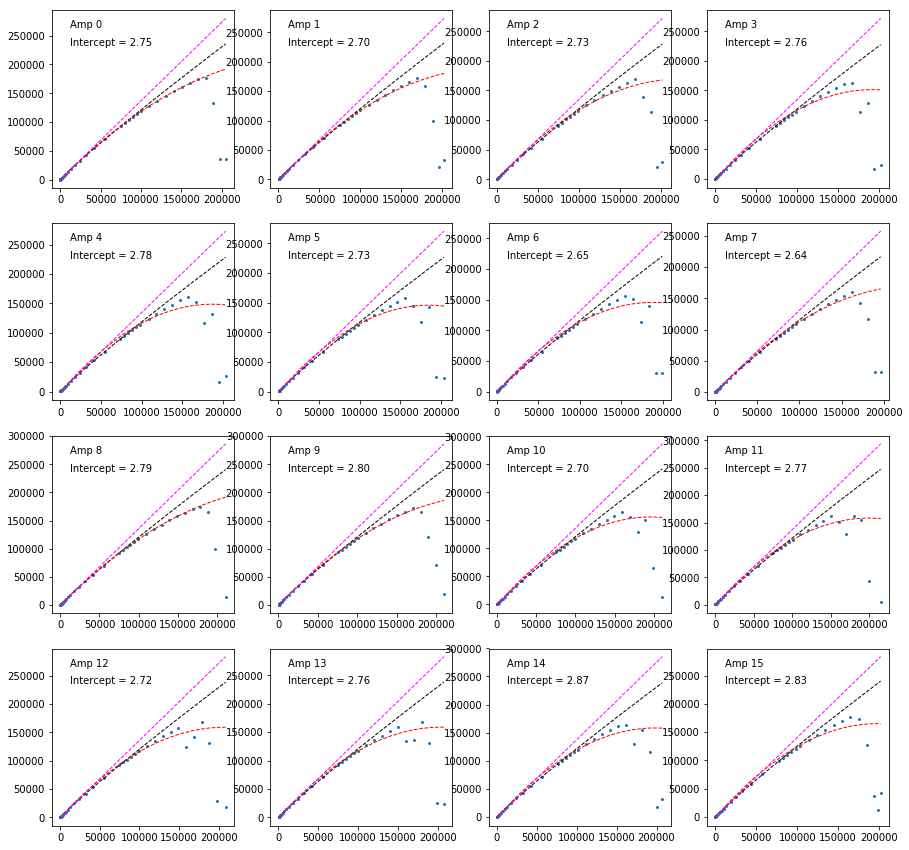

In [115]:
plot_PTC(ccd_data, 0)

## Test area

### Sandbox

In [97]:
sensor_num = 0
amp_num = 0    
sensor_names = ['S00', 'S01', 'S02', 'S10', 'S11', 'S12', 'S20', 'S21', 'S22']
sensor_name = sensor_names[sensor_num]

### Plots

In [126]:
def plot_gains(ccd_data, ccd_num):
    gains = []
    
    for amp in range(16):
        gains.append([x[3] for x in ccd_data[ccd_num][:,amp]])
    
    fig, axs = plt.subplots(4,4, figsize=(15, 15))

    axs = axs.reshape((16,))

    amp_num = 0
    for ax in axs:
        bins = np.linspace(min(gains[amp_num]), max(gains[amp_num]), 50)
        ax.hist(gains[amp_num], bins=bins, alpha=0.5, label='Amp %i' %amp_num)
        ax.text(0.6, 0.6, "Median: %.3f" %np.median(gains[amp_num]), transform=ax.transAxes)
        ax.set_xlabel("Gain")
        ax.legend()    
        amp_num += 1

    plt.show()

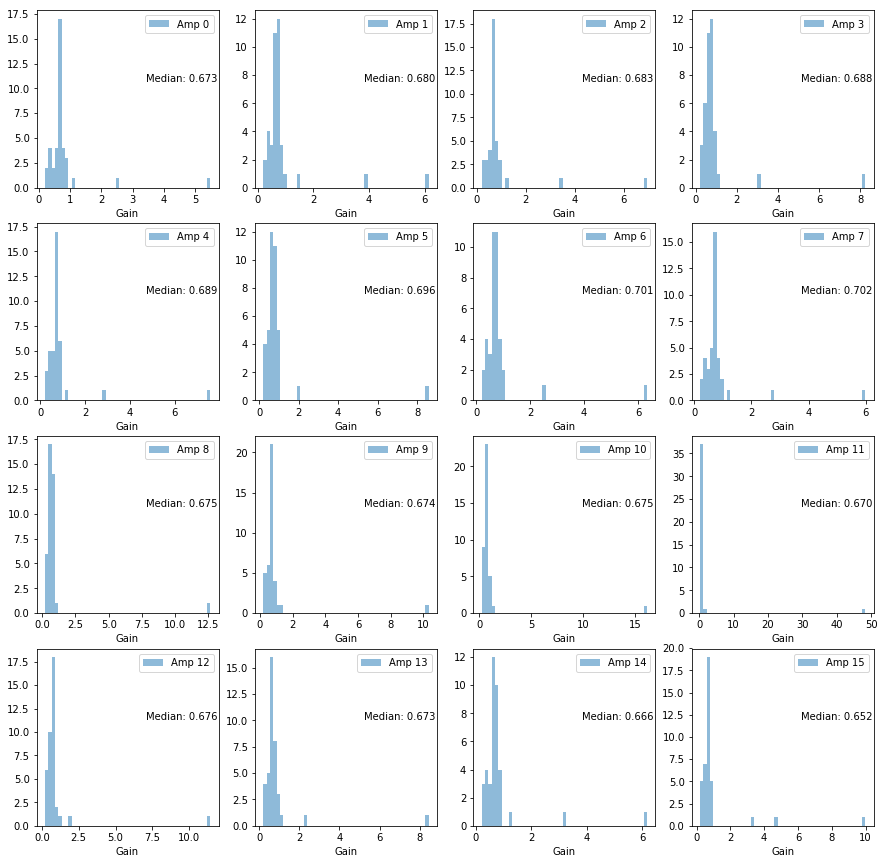

In [127]:
plot_gains(ccd_data, 0)

In [150]:
gain_means, exps_means, gain_stds, exps_stds = [], [], [], []

full_array = np.asarray(ccd_3_gains)

for visit in range(39):
    gain_means.append(np.mean(full_array[:,visit]['gain']))
    gain_stds.append(np.std(full_array[:,visit]['gain']))
    exps_means.append(np.mean(full_array[:,visit]['exp_time']))
    exps_stds.append(np.std(full_array[:,visit]['exp_time']))

In [157]:
#determine when sensor starts to get saturated
thresh_noise_to_sig = 0.1
noise_to_sig = np.asarray(gain_stds) / np.asarray(gain_means)
sat_start = 0
while sat_start < len(noise_to_sig):
    if noise_to_sig[sat_start] > thresh_noise_to_sig:
        break
    sat_start += 1


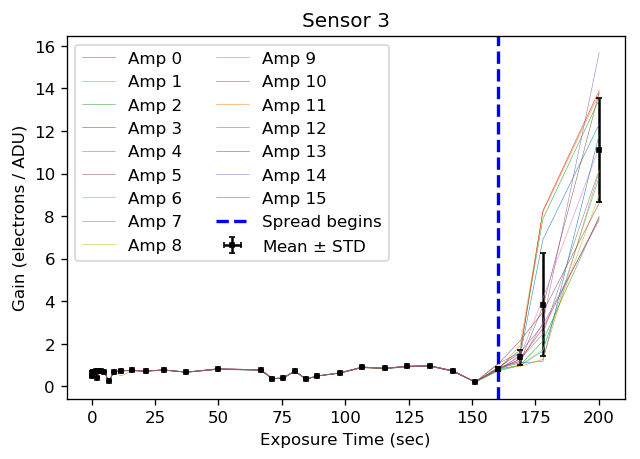

In [159]:
plt.figure()
amp_num = 0
while amp_num < 16:
    plt.plot(ccd_3_gains[amp_num]['exp_time'], ccd_3_gains[amp_num]['gain'], label='Amp %i' %amp_num, lw=0.3)
    amp_num += 1

plt.axvline(x=exps_means[sat_start], color='blue', ls='dashed', lw=2, label='Spread begins')

plt.errorbar(exps_means, gain_means, xerr=exps_stds, yerr=gain_stds, 
             fmt='s', markersize=2, color='black', capsize=2, label='Mean $\pm$ STD')
    
plt.legend(ncol=2)
plt.xlabel("Exposure Time (sec)")
plt.ylabel("Gain (electrons / ADU)")
plt.title("Sensor 3")
plt.show()

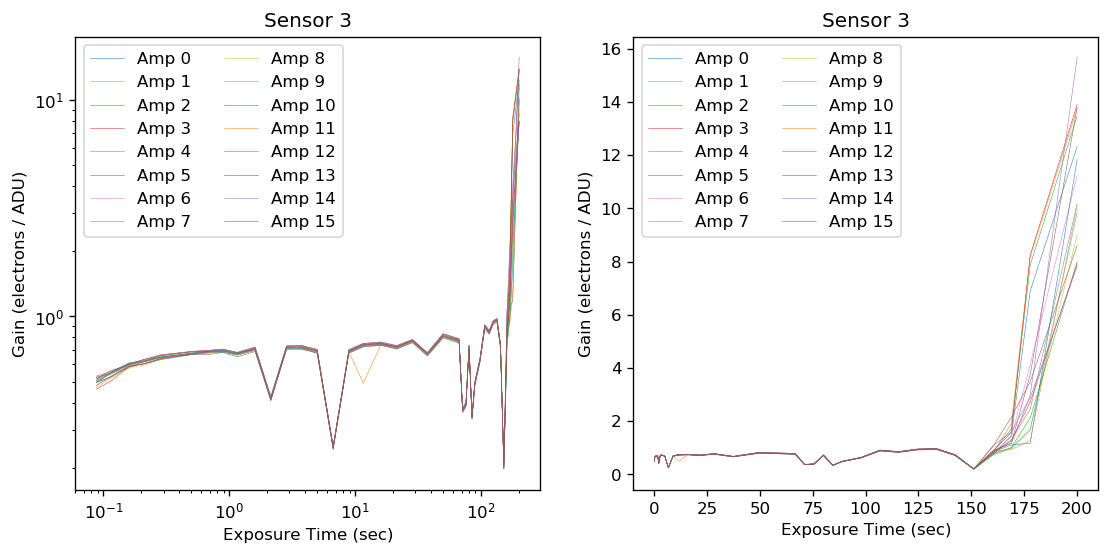

In [84]:
#Plot log gain versus log exposure time for all amps
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5))

amp_num = 0
while amp_num < 16:
    ax1.loglog(ccd_3_gains[amp_num]['exp_time'], ccd_3_gains[amp_num]['gain'], label='Amp %i' %amp_num, lw=0.3)
    ax2.plot(ccd_3_gains[amp_num]['exp_time'], ccd_3_gains[amp_num]['gain'], label='Amp %i' %amp_num, lw=0.3)
    amp_num += 1

ax1.set_title("Sensor 3")
ax1.set_ylabel("Gain (electrons / ADU)")
ax1.set_xlabel("Exposure Time (sec)")
ax1.legend(ncol=2)
ax2.set_title("Sensor 3")
ax2.set_ylabel("Gain (electrons / ADU)")
ax2.set_xlabel("Exposure Time (sec)")
ax2.legend(ncol=2)
plt.show()


In [ ]:
#Find exposure time at which gain starts to go wild
for amp_num in range(16):
    gains = sorted(ccd_3_gains[amp_num]['gain'])

## End test area

In [ ]:
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)
## butler.getKeys('raw')
## help(butler)
visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FLAT', 'testType': 'FLAT'})
gain = {}
exp_time = {}

i = 1
for visit1, visit2 in zip(visits[:-1:2], visits[1::2]): # loop over pairs of images
    # Get ISR data for first image
    dId = {'visit': visit1, 'detector': 2}
    raw1 = butler.get('raw', **dId)
    bias1 = butler.get('bias', **dId)
    time1 = raw1.getInfo().getVisitInfo().getExposureTime()
    
    # Get ISR data for second image
    dId = {'visit': visit2, 'detector': 2}
    raw2 = butler.get('raw', **dId)
    bias2 = butler.get('bias', **dId)
    time2 = raw2.getInfo().getVisitInfo().getExposureTime()
    if abs(time1 - time2) > 0.01:
        "Mismatched exptimes"
        continue
    
    # run ISR on both images
    result1 = isr.run(raw1, bias=bias1)
    result2 = isr.run(raw2, bias=bias2)
    
    detector = result1.exposure.getDetector()
    amp = detector[3]

    sub_im1 = result1.exposure.getMaskedImage()[amp.getBBox()]
    #arr1 = sub_im1.getImage().getArray()
    sub_im2 = result2.exposure.getMaskedImage()[amp.getBBox()]
    #arr2 = sub_im2.getImage().getArray()
    
    # From RHL, 1/g = <(I1-I2)**2/(I1+I2)>
    diff_im = sub_im1.clone()
    diff_im -= sub_im2
    
    sum_im = sub_im1.clone()
    sum_im += sub_im2
    
    diff_im *= diff_im
    diff_im /= sum_im
    
    stats = afwMath.makeStatistics(diff_im, afwMath.MEDIAN | afwMath.MEAN)
    # Compute gain for this amp.
    gain[visit1] = 1/stats.getValue(afwMath.MEAN)
    exp_time[visit1] = time1
    print("visit %i,%i -- %i of %i -- gain=%f, exposure time(s)=%f"%(visit1, visit2, i, len(visits)/2, gain[visit1], exp_time[visit1], ))
    i += 1

In [ ]:
afw_display.mtv(sub_im1) # display an example image

In [ ]:
visit_keys = exp_time.keys()
x = [exp_time[visit] for visit in visit_keys]
y = [gain[visit] for visit in visit_keys]

In [ ]:
plt.scatter(x, y)
plt.ylim(0, 1)